<a href="https://colab.research.google.com/github/nxxk23/PROJECT/blob/main/Classification/Binary3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# **class**
```
* (0) good       34646
* (2) average     9768
* (1) bad         8206
```



In [2]:
import pandas as pd
binary = pd.read_excel('/content/drive/MyDrive/ckdresearch2023/Assign/Assign8 : SplitFold /binary_3_Group_5_Fold.xlsx')
binary = binary.iloc[:, 1:]
binary

,PatientUID,PatientVisitUID,Slopes,G1M2:ARB,G3M1:Statin,G5M2:NSAIDs,G1M5:Diuretic,G1M7:Beta blocker,G1M3:Dihydropyridine CCB,G1M6:MRA,...,newL25:Parathyroid hormone,newL26:Vitamin D,newL27:UrineAlbumin/Cr ratio,newL28:UrineProtein/Cr ratio,newL29:UrineVolume (24hrs),newL30:UrineUrea (24hrs),newL31:UrineSodium (24hrs),newL32:UrineProtein (24hrs),Group,Fold
0,2299,6947220,-12.812245,35,0,1,35,0,0,0,...,1,1,1,1,1,1,1,1,good,1
1,2299,3386255,-7.158596,90,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,good,1
2,2299,5812902,-6.063710,100,100,34,0,0,0,0,...,1,1,1,1,1,1,1,1,good,1
3,2299,4546471,5.550691,90,90,0,0,0,0,0,...,1,1,1,1,1,1,1,1,bad,1
4,2299,8186767,28.287500,100,0,15,0,0,0,0,...,1,1,1,1,1,1,1,1,bad,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52615,3319961,9270330,-4.256753,100,100,0,0,0,0,0,...,1,1,0,0,1,1,1,1,good,4
52616,3319971,9270331,-0.692078,0,100,0,0,0,0,0,...,1,1,0,0,1,1,1,1,good,0
52617,3320048,9242721,7.217875,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,bad,1
52618,3320050,9257281,-32.794557,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,good,2


In [3]:
data = binary.copy()

In [4]:
data = data.sort_values(['PatientUID', 'PatientVisitUID'])
data['TimeDiff'] = data.groupby('PatientUID')['LabCwhen'].diff().dt.days / 365
data['TimeDiff'] = data['TimeDiff'].fillna(0)

In [5]:
data['time_t1'] = pd.to_datetime(data['time_t1'])

In [6]:
columns_to_encode = ['VisitLocation', 'Group', 'NATNL']

# Apply label encoding using map
for column in columns_to_encode:
    encoding_map = {category: i for i, category in enumerate(data[column].unique())}
    data[column] = data[column].map(encoding_map)

In [7]:
data.head(3)

,PatientUID,PatientVisitUID,Slopes,G1M2:ARB,G3M1:Statin,G5M2:NSAIDs,G1M5:Diuretic,G1M7:Beta blocker,G1M3:Dihydropyridine CCB,G1M6:MRA,...,newL26:Vitamin D,newL27:UrineAlbumin/Cr ratio,newL28:UrineProtein/Cr ratio,newL29:UrineVolume (24hrs),newL30:UrineUrea (24hrs),newL31:UrineSodium (24hrs),newL32:UrineProtein (24hrs),Group,Fold,TimeDiff
1,2299,3386255,-7.158596,90,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,1,0.000000
3,2299,4546471,5.550691,90,90,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1.131507
2,2299,5812902,-6.063710,100,100,34,0,0,0,0,...,1,1,1,1,1,1,1,0,1,1.191781


In [8]:
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.preprocessing import StandardScaler

X = data.drop(['Group', 'PatientUID', 'PatientVisitUID', 'eGFR_t1', 'time_t1', 'StartDTTM', 'EndDttm',
               'LabCwhen', 'VisitLocation', 'LabLocation','Fold'], axis=1)
y = data['Group']

num_folds = 5  # Specify the number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)  # Set shuffle to True

# Get the unique fold values
all_folds = data['Fold'].unique()

X_train_scaled_list = []
y_train_list = []  # List to store y_train for each fold
X_test_scaled_list = []  # List to store X_test_scaled for each fold
y_test_list = []  # List to store y_test for each fold

for train_folds, test_fold in kf.split(all_folds):
    train_folds = all_folds[train_folds]
    val_fold = all_folds[test_fold][0]

    # Select rows with the corresponding folds
    train_indices = data['Fold'].isin(train_folds)
    test_indices = data['Fold'] == val_fold

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    # Store the scaled data for each fold
    X_train_scaled_list.append(X_train_scaled)
    y_train_list.append(y_train)
    X_test_scaled_list.append(X_test_scaled)
    y_test_list.append(y_test)

# Access the X_train_scaled and y_train for each fold
for fold, (X_train_scaled_fold, y_train_fold, X_test_scaled_fold, y_test_fold, train_fold_indices) in enumerate(
    zip(X_train_scaled_list, y_train_list, X_test_scaled_list, y_test_list, kf.split(all_folds))
):
    train_folds, test_fold = train_fold_indices

    print(f"Fold {fold + 1}:")
    print(f"Training set size : {X_train_scaled_fold.shape}")
    print(f"Test set size: {X_test_scaled_fold.shape}")
    print(f"Folds in training set: {train_folds.tolist()}")
    print(f"Folds in test set: {test_fold}")
    print("---\n")

Fold 1:
Training set size : (41978, 120)
Test set size: (10642, 120)
Folds in training set: [0, 1, 2, 4]
Folds in test set: [3]
---

Fold 2:
Training set size : (42017, 120)
Test set size: (10603, 120)
Folds in training set: [0, 1, 2, 3]
Folds in test set: [4]
---

Fold 3:
Training set size : (42027, 120)
Test set size: (10593, 120)
Folds in training set: [0, 1, 3, 4]
Folds in test set: [2]
---

Fold 4:
Training set size : (42274, 120)
Test set size: (10346, 120)
Folds in training set: [0, 2, 3, 4]
Folds in test set: [1]
---

Fold 5:
Training set size : (42184, 120)
Test set size: (10436, 120)
Folds in training set: [1, 2, 3, 4]
Folds in test set: [0]
---



In [9]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(42184, 120)
(10436, 120)
(42184,)
(10436,)


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# **Define**

In [11]:
X = data.drop(['Group','time_t1','StartDTTM','EndDttm','LabCwhen'], axis=1)
y = data['Group']

## **epoch 30**

In [43]:
label_encoder = LabelEncoder()
data['Group'] = label_encoder.fit_transform(data['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
all_folds = data['Fold'].unique()

accuracy_per_fold = []
conf_mat_list = []

precision_per_fold = []
recall_per_fold = []
f1_per_fold = []

loss_per_fold = []
all_train_loss = []
all_val_loss = []

# Create an instance of SMOTE
smote = SMOTE()

In [44]:
for fold, (train_folds, test_fold) in enumerate(kf.split(all_folds)):
    train_folds = all_folds[train_folds]
    test_fold = all_folds[test_fold][0]
    train_indices = data['Fold'].isin(train_folds)
    test_indices = data['Fold'] == test_fold

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # Apply SMOTE only on the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # scale
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # encode y_train and y_test
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_test_encoded = label_encoder.transform(y_test)
    y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
    y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)

    model0 = Sequential([
        Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model0.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model0.fit(X_train_scaled, y_train_one_hot,
                        batch_size=500,
                        epochs=30,
                        verbose=0,
                        validation_data=(X_test_scaled, y_test_one_hot))

    # Evaluate on train set
    scores = model0.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
    loss_per_fold.append(scores[0])

    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    y_pred = model0.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)
    conf_mat = confusion_matrix(y_test_encoded, y_pred_classes)
    conf_mat_list.append(conf_mat)


    accuracy = accuracy_score(y_test_encoded, y_pred_classes)
    precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')
    recall = recall_score(y_test_encoded, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_encoded, y_pred_classes, average='weighted')

    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    print(f"Fold {fold + 1} - Loss: {loss_per_fold[-1]:.4f}, Accuracy: {accuracy_per_fold[-1]*100:.2f}%")
    print(f"Precision: {precision_per_fold[-1]:.4f}, Recall: {recall_per_fold[-1]:.4f}, F1-Score: {f1_per_fold[-1]:.4f}")

324/324 [==============================] - 1s 2ms/step
Fold 1 - Loss: 0.0595, Accuracy: 97.67%
Precision: 0.9768, Recall: 0.9767, F1-Score: 0.9767
327/327 [==============================] - 1s 1ms/step
Fold 2 - Loss: 0.0662, Accuracy: 97.63%
Precision: 0.9764, Recall: 0.9763, F1-Score: 0.9763
332/332 [==============================] - 1s 1ms/step
Fold 3 - Loss: 0.0699, Accuracy: 97.60%
Precision: 0.9764, Recall: 0.9760, F1-Score: 0.9761
332/332 [==============================] - 1s 2ms/step
Fold 4 - Loss: 0.0698, Accuracy: 97.63%
Precision: 0.9776, Recall: 0.9763, F1-Score: 0.9766
333/333 [==============================] - 1s 1ms/step
Fold 5 - Loss: 0.0493, Accuracy: 98.02%
Precision: 0.9804, Recall: 0.9802, F1-Score: 0.9802


In [45]:
from collections import Counter

print("Class distribution in y_train_resampled:", Counter(y_train_resampled))
print("Class distribution in y_test:", Counter(y_test))

Class distribution in y_train_resampled: Counter({0: 27656, 1: 27656, 2: 27656})
Class distribution in y_test: Counter({0: 6990, 2: 1952, 1: 1700})


In [46]:
y_pred

array([[9.9999994e-01, 0.0000000e+00, 7.5931540e-25],
       [9.5287211e-02, 2.1092887e-12, 9.0471280e-01],
       [9.9678028e-01, 3.3091863e-17, 3.2196487e-03],
       ...,
       [9.9999994e-01, 0.0000000e+00, 1.7742406e-21],
       [9.9999309e-01, 1.6239025e-25, 6.9223406e-06],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [47]:
y_test_encoded

array([0, 2, 0, ..., 0, 0, 0])

In [48]:
y_pred_classes

array([0, 2, 0, ..., 0, 0, 0])

### **plot**

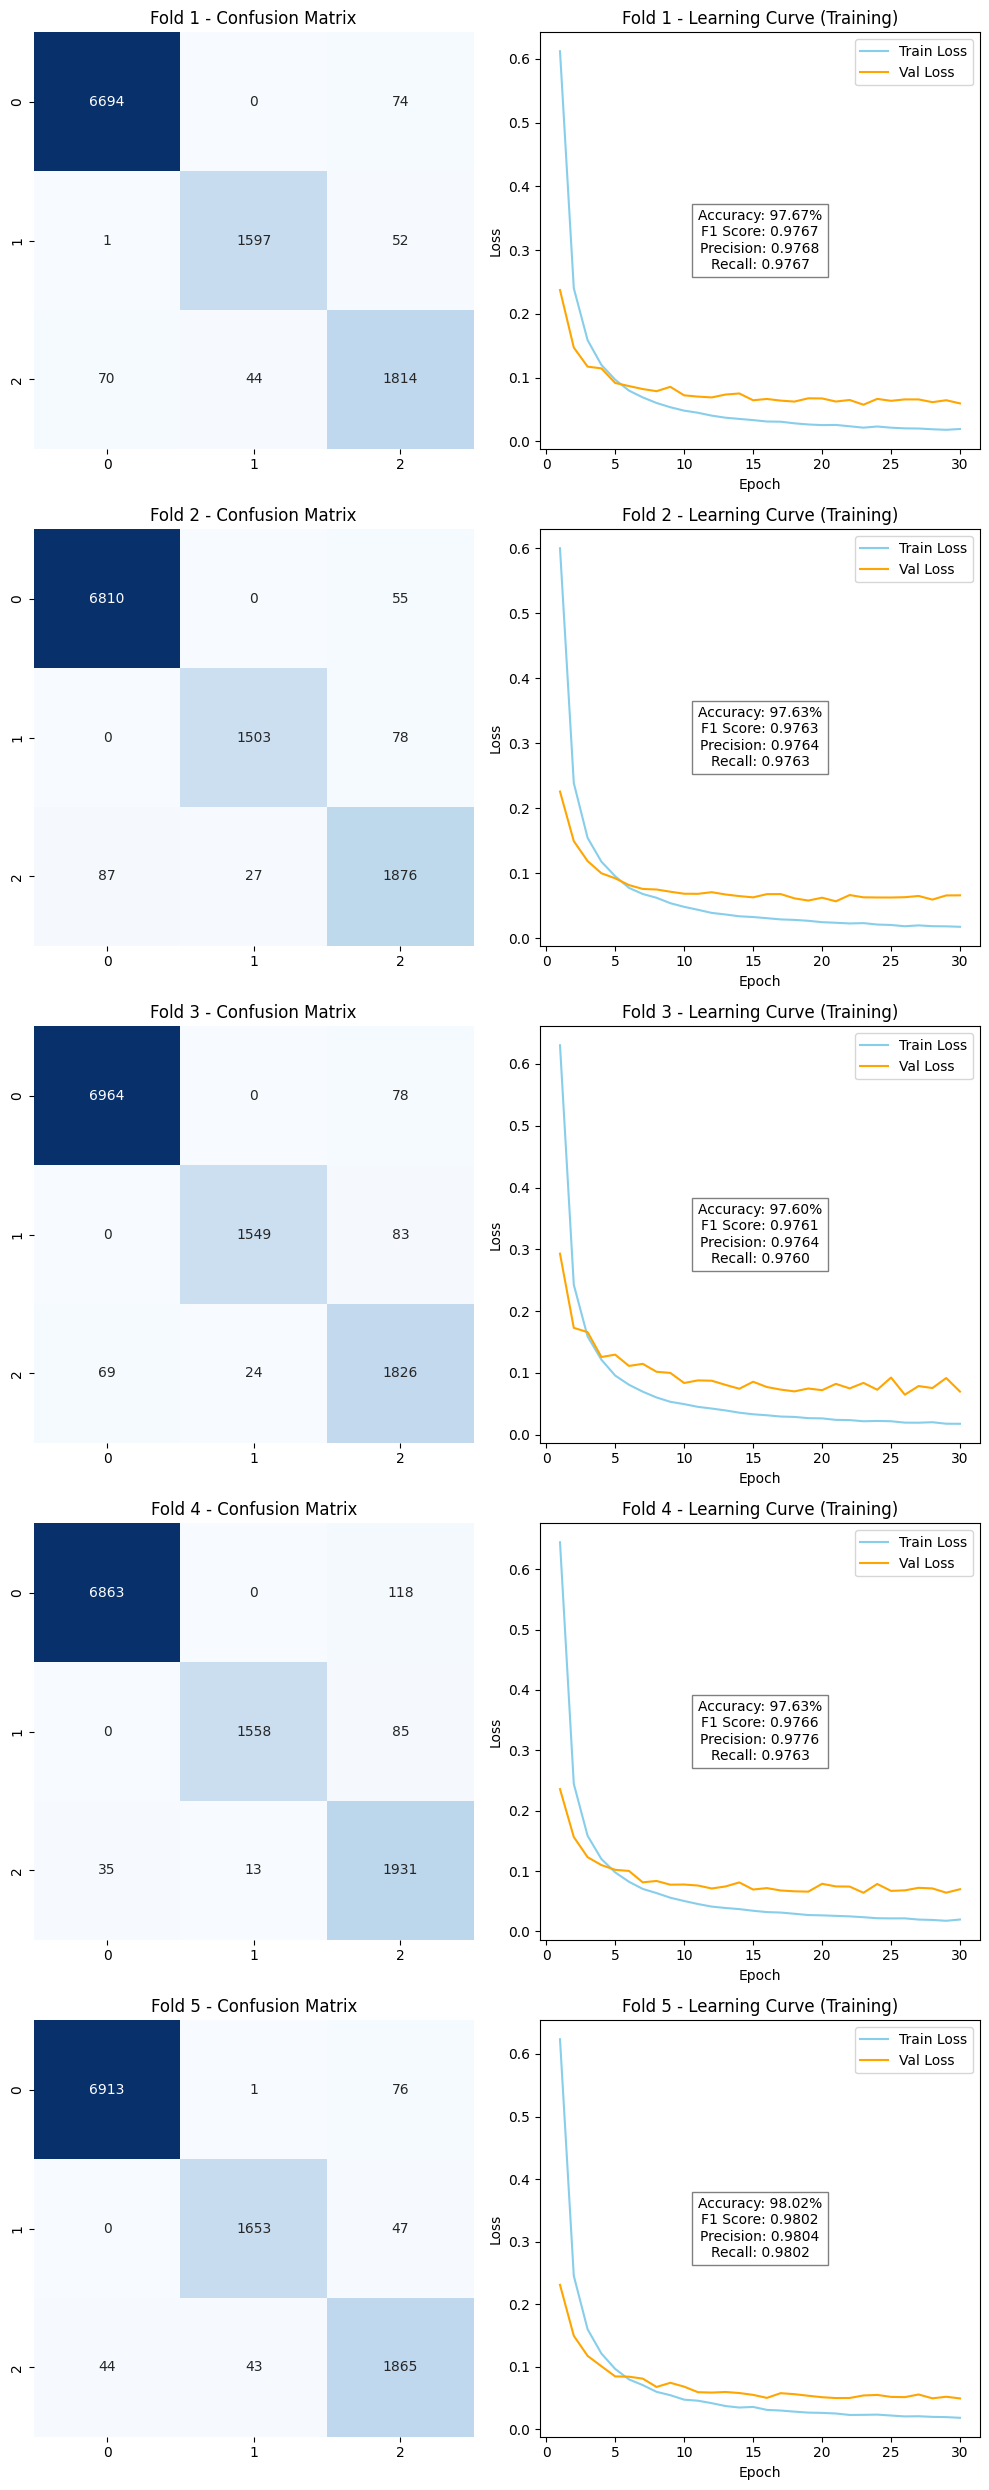

In [49]:
import seaborn as sns

fig, axes = plt.subplots(nrows=num_folds, ncols=2, figsize=(10, 5 * num_folds))
fig.subplots_adjust(hspace=0.5)

for fold in range(num_folds):
    conf_mat = conf_mat_list[fold]
    scores = loss_per_fold[fold]

    # Subplot 1: Confusion Matrix
    ax1 = axes[fold, 0]
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_title(f'Fold {fold + 1} - Confusion Matrix')

    # Subplot 2: Learning Curve (Training)
    ax2 = axes[fold, 1]
    ax2.plot(range(1, len(all_train_loss[fold]) + 1), all_train_loss[fold], color='skyblue', label='Train Loss')
    ax2.plot(range(1, len(all_val_loss[fold]) + 1), all_val_loss[fold], color='orange', label='Val Loss')

    ax2.set_title(f'Fold {fold + 1} - Learning Curve (Training)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Annotate with final values
    ax2.text(0.5, 0.5, f'Accuracy: {accuracy_per_fold[fold]*100:.2f}%\nF1 Score: {f1_per_fold[fold]:.4f}\nPrecision: {precision_per_fold[fold]:.4f}\nRecall: {recall_per_fold[fold]:.4f}',
             horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Display the subplots
plt.tight_layout()
plt.show()


## **epoch 50**

In [12]:
label_encoder = LabelEncoder()
data['Group'] = label_encoder.fit_transform(data['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
all_folds = data['Fold'].unique()

accuracy_per_fold = []
conf_mat_list = []

precision_per_fold = []
recall_per_fold = []
f1_per_fold = []

loss_per_fold = []
all_train_loss = []
all_val_loss = []

# Create an instance of SMOTE
smote = SMOTE()

In [13]:
for fold, (train_folds, test_fold) in enumerate(kf.split(all_folds)):
    train_folds = all_folds[train_folds]
    test_fold = all_folds[test_fold][0]
    train_indices = data['Fold'].isin(train_folds)
    test_indices = data['Fold'] == test_fold

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # Apply SMOTE only on the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # scale
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # encode y_train and y_test
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_test_encoded = label_encoder.transform(y_test)
    y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
    y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)

    model = Sequential([
        Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train_one_hot,
                        batch_size=500,
                        epochs=50,
                        verbose=0,
                        validation_data=(X_test_scaled, y_test_one_hot))

    # Evaluate on train set
    scores = model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
    loss_per_fold.append(scores[0])

    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)
    conf_mat = confusion_matrix(y_test_encoded, y_pred_classes)
    conf_mat_list.append(conf_mat)


    accuracy = accuracy_score(y_test_encoded, y_pred_classes)
    precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')
    recall = recall_score(y_test_encoded, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_encoded, y_pred_classes, average='weighted')

    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    print(f"Fold {fold + 1} - Loss: {loss_per_fold[-1]:.4f}, Accuracy: {accuracy_per_fold[-1]*100:.2f}%")
    print(f"Precision: {precision_per_fold[-1]:.4f}, Recall: {recall_per_fold[-1]:.4f}, F1-Score: {f1_per_fold[-1]:.4f}")

332/332 [==============================] - 1s 2ms/step
Fold 1 - Loss: 0.0899, Accuracy: 97.58%
Precision: 0.9760, Recall: 0.9758, F1-Score: 0.9759
324/324 [==============================] - 1s 1ms/step
Fold 2 - Loss: 0.0616, Accuracy: 97.86%
Precision: 0.9789, Recall: 0.9786, F1-Score: 0.9787
333/333 [==============================] - 1s 1ms/step
Fold 3 - Loss: 0.0585, Accuracy: 97.90%
Precision: 0.9790, Recall: 0.9790, F1-Score: 0.9790
327/327 [==============================] - 1s 2ms/step
Fold 4 - Loss: 0.0635, Accuracy: 97.83%
Precision: 0.9784, Recall: 0.9783, F1-Score: 0.9784
332/332 [==============================] - 1s 2ms/step
Fold 5 - Loss: 0.0715, Accuracy: 97.93%
Precision: 0.9798, Recall: 0.9793, F1-Score: 0.9795


In [14]:
from collections import Counter

print("Class distribution in y_train_resampled:", Counter(y_train_resampled))
print("Class distribution in y_test:", Counter(y_test))

Class distribution in y_train_resampled: Counter({0: 27665, 1: 27665, 2: 27665})
Class distribution in y_test: Counter({0: 6981, 2: 1979, 1: 1643})


In [15]:
y_pred

array([[9.9999994e-01, 0.0000000e+00, 7.5423833e-30],
       [1.2540532e-27, 9.9999994e-01, 1.5178923e-10],
       [9.9999994e-01, 0.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [9.9999964e-01, 5.4239709e-26, 3.2620125e-07]], dtype=float32)

In [16]:
y_test_encoded

array([0, 1, 0, ..., 0, 0, 0])

In [17]:
y_pred_classes

array([0, 1, 0, ..., 0, 0, 0])

### **plot**

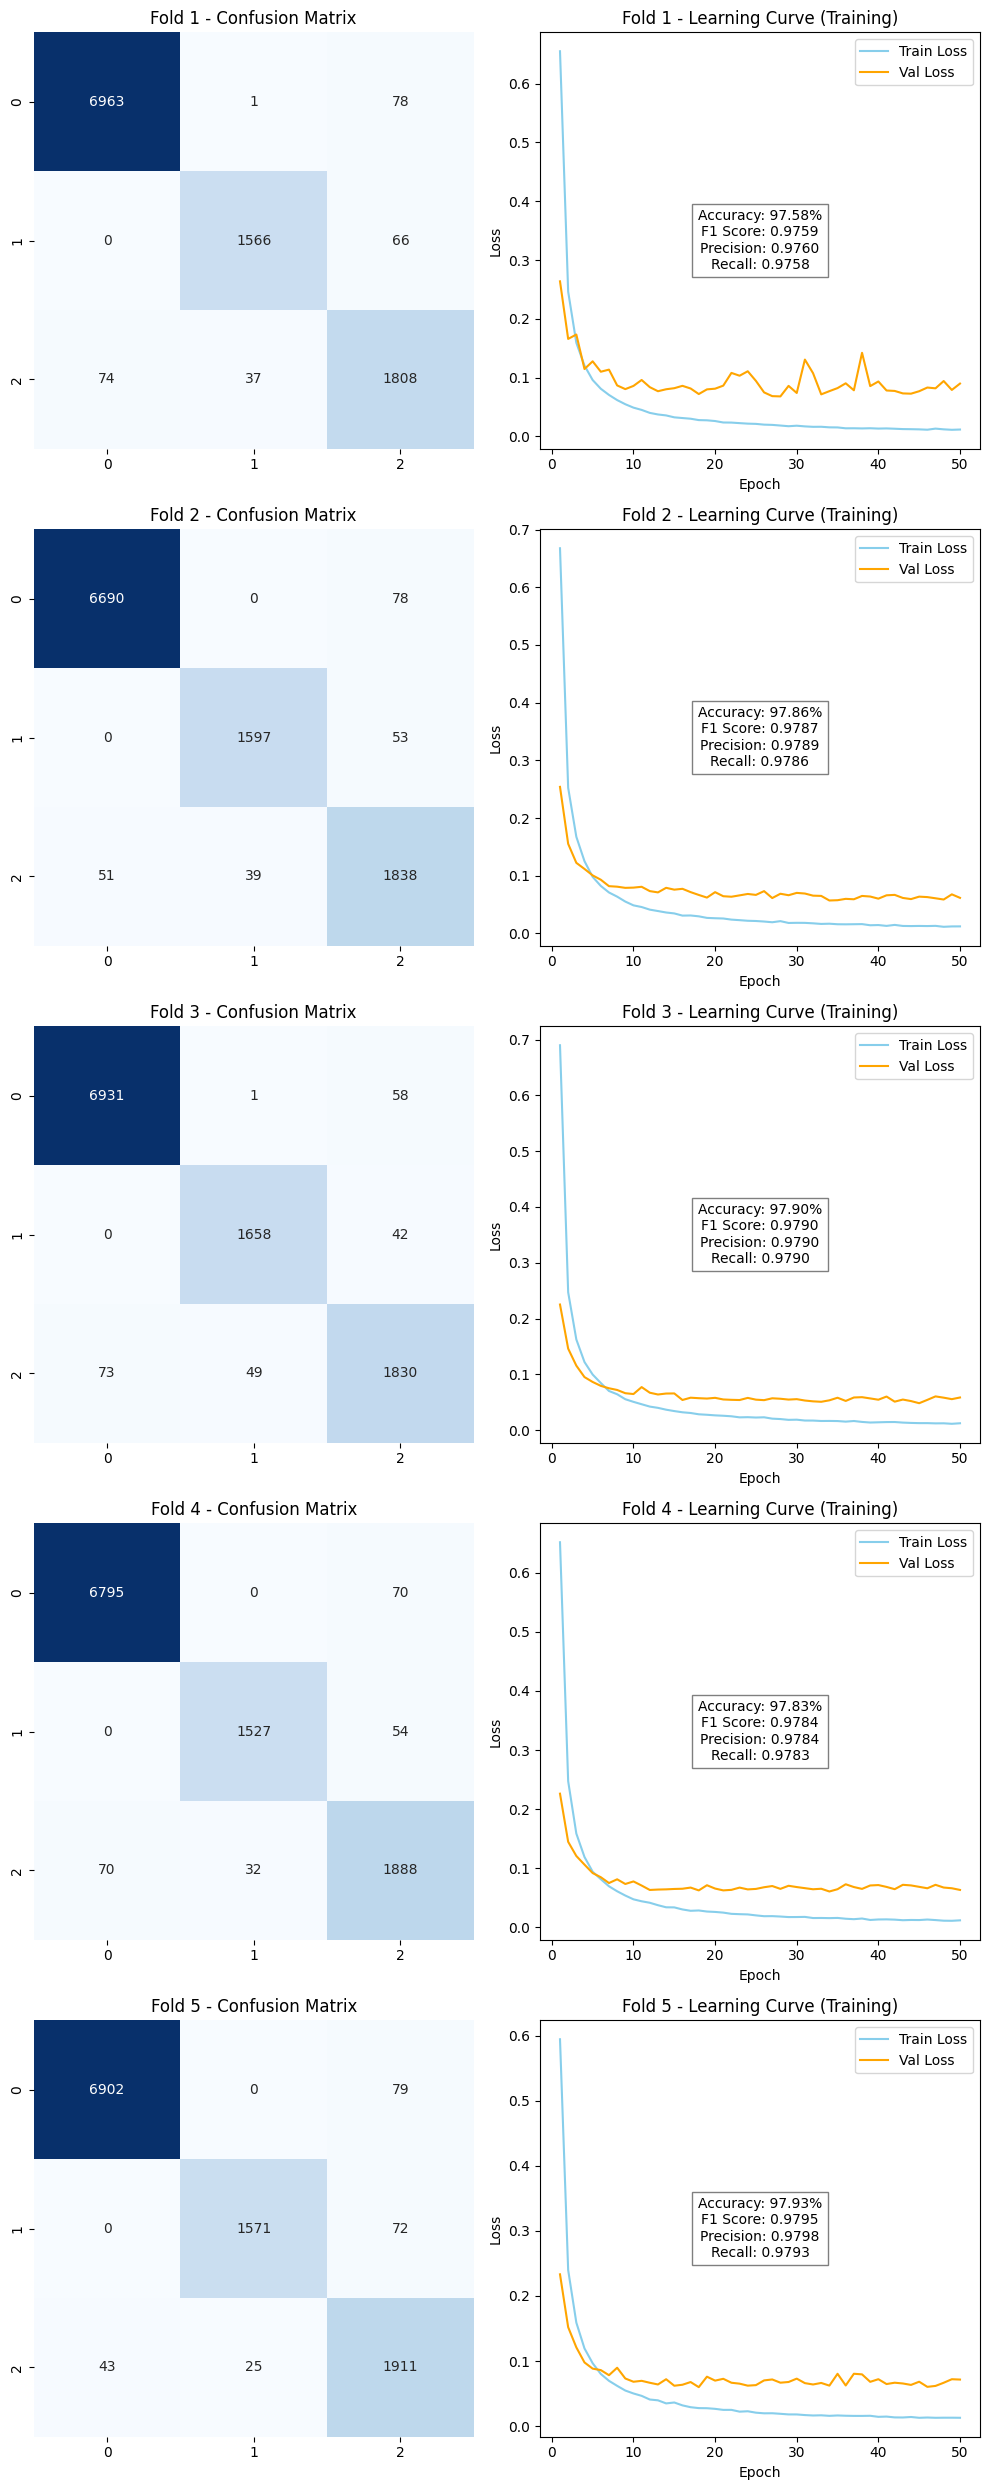

In [19]:
import seaborn as sns

fig, axes = plt.subplots(nrows=num_folds, ncols=2, figsize=(10, 5 * num_folds))
fig.subplots_adjust(hspace=0.5)

for fold in range(num_folds):
    conf_mat = conf_mat_list[fold]
    scores = loss_per_fold[fold]

    # Subplot 1: Confusion Matrix
    ax1 = axes[fold, 0]
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_title(f'Fold {fold + 1} - Confusion Matrix')

    # Subplot 2: Learning Curve (Training)
    ax2 = axes[fold, 1]
    ax2.plot(range(1, len(all_train_loss[fold]) + 1), all_train_loss[fold], color='skyblue', label='Train Loss')
    ax2.plot(range(1, len(all_val_loss[fold]) + 1), all_val_loss[fold], color='orange', label='Val Loss')

    ax2.set_title(f'Fold {fold + 1} - Learning Curve (Training)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Annotate with final values
    ax2.text(0.5, 0.5, f'Accuracy: {accuracy_per_fold[fold]*100:.2f}%\nF1 Score: {f1_per_fold[fold]:.4f}\nPrecision: {precision_per_fold[fold]:.4f}\nRecall: {recall_per_fold[fold]:.4f}',
             horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Display the subplots
plt.tight_layout()
plt.show()


## **epoch 100**

In [52]:
label_encoder = LabelEncoder()
data['Group'] = label_encoder.fit_transform(data['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
all_folds = data['Fold'].unique()

accuracy_per_fold = []
conf_mat_list = []

precision_per_fold = []
recall_per_fold = []
f1_per_fold = []

loss_per_fold = []
all_train_loss = []
all_val_loss = []

# Create an instance of SMOTE
smote = SMOTE()

In [53]:
for fold, (train_folds, test_fold) in enumerate(kf.split(all_folds)):
    train_folds = all_folds[train_folds]
    test_fold = all_folds[test_fold][0]
    train_indices = data['Fold'].isin(train_folds)
    test_indices = data['Fold'] == test_fold

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # Apply SMOTE only on the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # scale
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # encode y_train and y_test
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_test_encoded = label_encoder.transform(y_test)
    y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
    y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)

    model1 = Sequential([
        Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model1.fit(X_train_scaled, y_train_one_hot,
                        batch_size=500,
                        epochs=100,
                        verbose=0,
                        validation_data=(X_test_scaled, y_test_one_hot))

    # Evaluate on train set
    scores = model1.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
    loss_per_fold.append(scores[0])

    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)
    conf_mat = confusion_matrix(y_test_encoded, y_pred_classes)
    conf_mat_list.append(conf_mat)


    accuracy = accuracy_score(y_test_encoded, y_pred_classes)
    precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')
    recall = recall_score(y_test_encoded, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_encoded, y_pred_classes, average='weighted')

    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    print(f"Fold {fold + 1} - Loss: {loss_per_fold[-1]:.4f}, Accuracy: {accuracy_per_fold[-1]*100:.2f}%")
    print(f"Precision: {precision_per_fold[-1]:.4f}, Recall: {recall_per_fold[-1]:.4f}, F1-Score: {f1_per_fold[-1]:.4f}")

332/332 [==============================] - 1s 2ms/step
Fold 1 - Loss: 0.0699, Accuracy: 97.95%
Precision: 0.9800, Recall: 0.9795, F1-Score: 0.9797
333/333 [==============================] - 0s 1ms/step
Fold 2 - Loss: 0.0535, Accuracy: 99.86%
Precision: 0.9986, Recall: 0.9986, F1-Score: 0.9986
332/332 [==============================] - 1s 1ms/step
Fold 3 - Loss: 0.1015, Accuracy: 99.74%
Precision: 0.9974, Recall: 0.9974, F1-Score: 0.9974
324/324 [==============================] - 1s 2ms/step
Fold 4 - Loss: 0.0639, Accuracy: 99.87%
Precision: 0.9987, Recall: 0.9987, F1-Score: 0.9987
327/327 [==============================] - 1s 2ms/step
Fold 5 - Loss: 0.0763, Accuracy: 99.86%
Precision: 0.9986, Recall: 0.9986, F1-Score: 0.9986


In [54]:
from collections import Counter

print("Class distribution in y_train_resampled:", Counter(y_train_resampled))
print("Class distribution in y_test:", Counter(y_test))

Class distribution in y_train_resampled: Counter({0: 27781, 1: 27781, 2: 27781})
Class distribution in y_test: Counter({0: 6865, 2: 1990, 1: 1581})


In [55]:
y_pred

array([[9.9999994e-01, 0.0000000e+00, 4.3930898e-32],
       [0.0000000e+00, 9.9999994e-01, 0.0000000e+00],
       [9.9999994e-01, 5.5509470e-33, 1.3134589e-13],
       ...,
       [2.5467136e-36, 1.0000000e+00, 2.4410899e-15],
       [0.0000000e+00, 1.0000000e+00, 4.8746038e-28],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [56]:
y_test_encoded

array([0, 1, 0, ..., 1, 1, 0])

In [57]:
y_pred_classes

array([0, 1, 0, ..., 1, 1, 0])

### **plot**

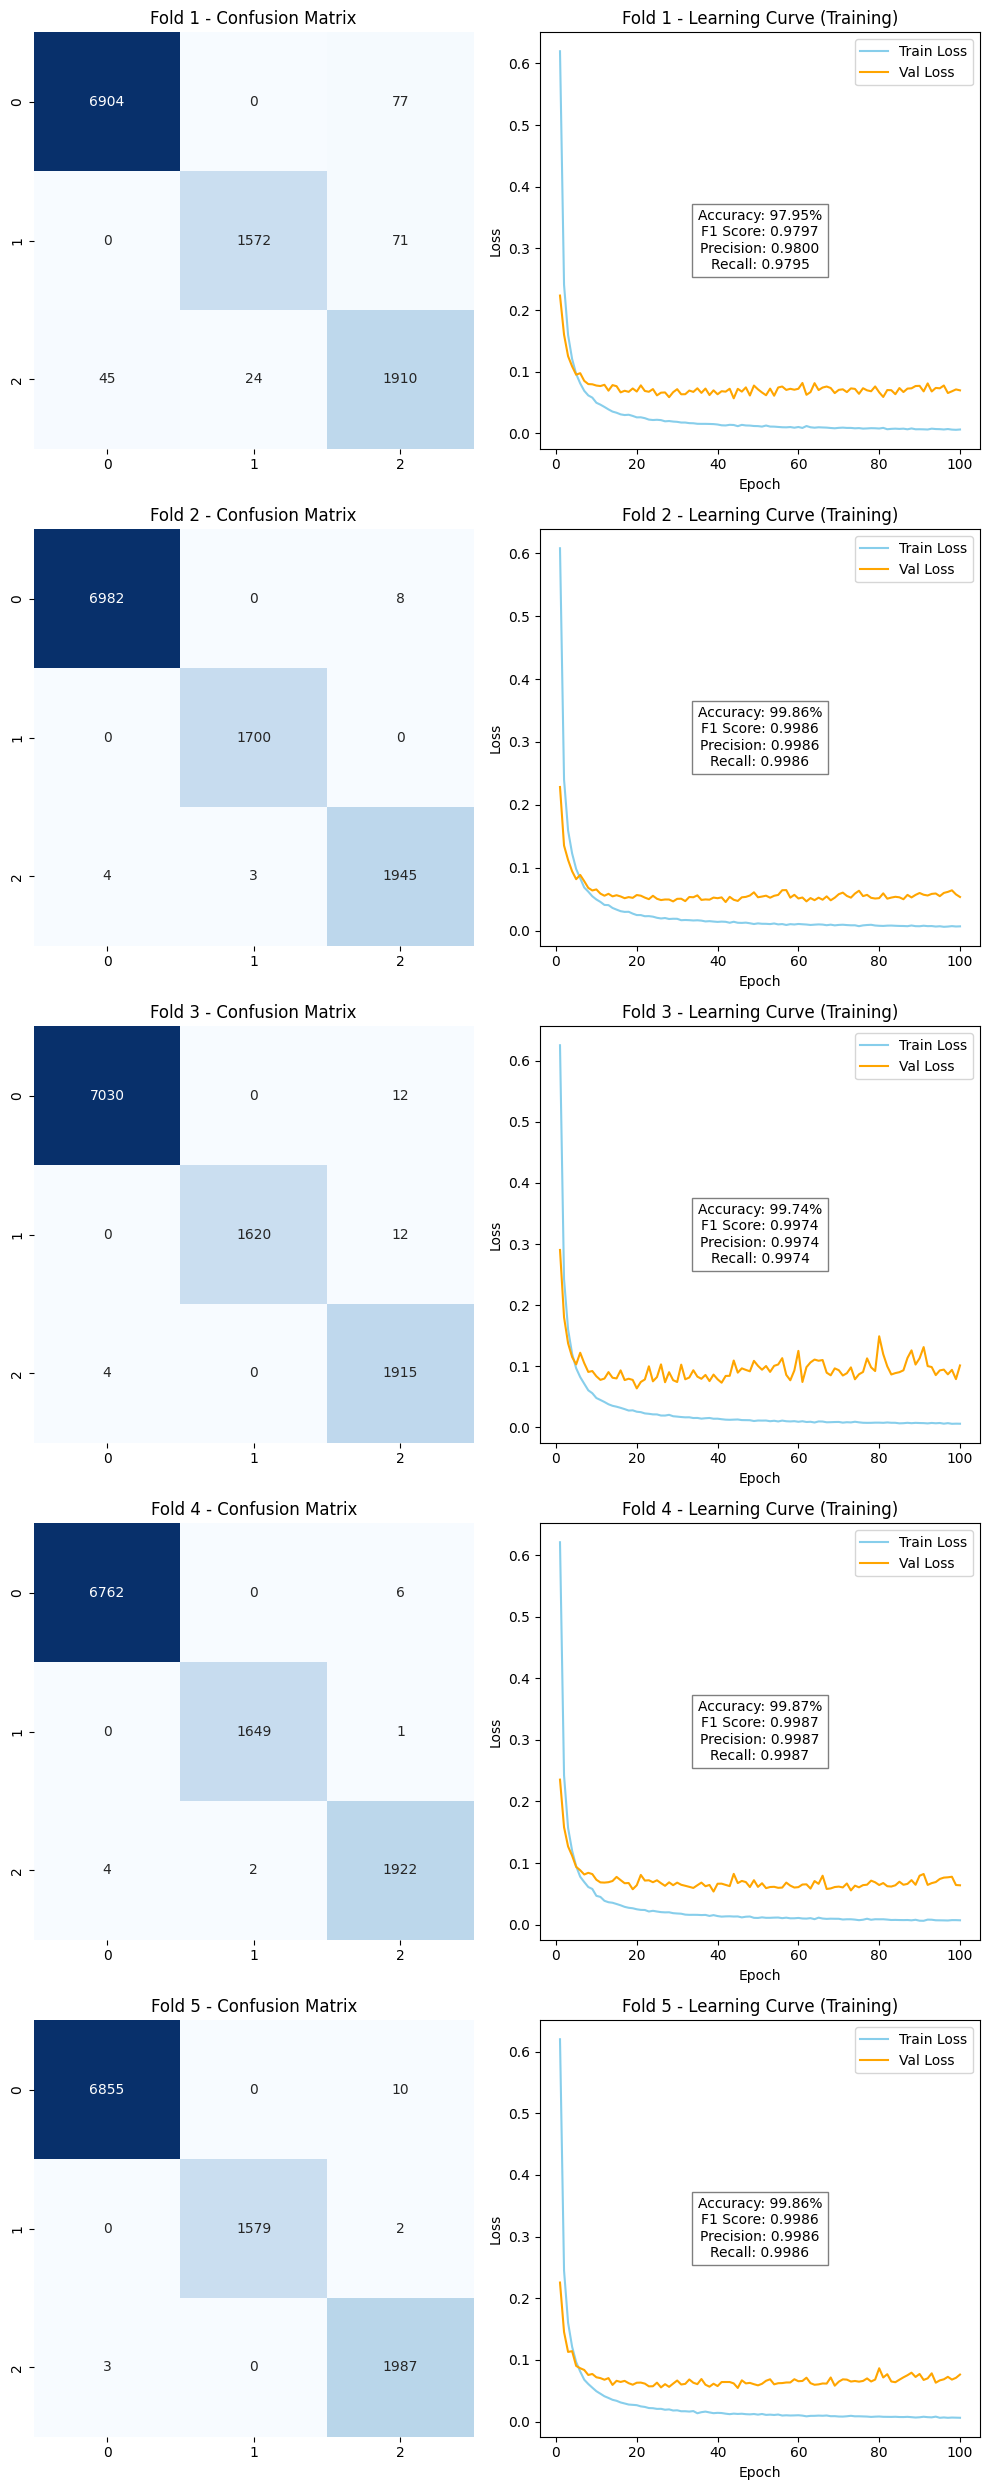

In [58]:
import seaborn as sns

fig, axes = plt.subplots(nrows=num_folds, ncols=2, figsize=(10, 5 * num_folds))
fig.subplots_adjust(hspace=0.5)

for fold in range(num_folds):
    conf_mat = conf_mat_list[fold]
    scores = loss_per_fold[fold]

    # Subplot 1: Confusion Matrix
    ax1 = axes[fold, 0]
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_title(f'Fold {fold + 1} - Confusion Matrix')

    # Subplot 2: Learning Curve (Training)
    ax2 = axes[fold, 1]
    ax2.plot(range(1, len(all_train_loss[fold]) + 1), all_train_loss[fold], color='skyblue', label='Train Loss')
    ax2.plot(range(1, len(all_val_loss[fold]) + 1), all_val_loss[fold], color='orange', label='Val Loss')

    ax2.set_title(f'Fold {fold + 1} - Learning Curve (Training)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Annotate with final values
    ax2.text(0.5, 0.5, f'Accuracy: {accuracy_per_fold[fold]*100:.2f}%\nF1 Score: {f1_per_fold[fold]:.4f}\nPrecision: {precision_per_fold[fold]:.4f}\nRecall: {recall_per_fold[fold]:.4f}',
             horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Display the subplots
plt.tight_layout()
plt.show()


## **early stopping**

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
label_encoder = LabelEncoder()
data['Group'] = label_encoder.fit_transform(data['Group'])

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=None)
all_folds = data['Fold'].unique()

accuracy_per_fold = []
conf_mat_list = []

precision_per_fold = []
recall_per_fold = []
f1_per_fold = []

loss_per_fold = []
all_train_loss = []
all_val_loss = []

# Create an instance of SMOTE
smote = SMOTE()

In [37]:
for fold, (train_folds, test_fold) in enumerate(kf.split(all_folds)):
    train_folds = all_folds[train_folds]
    test_fold = all_folds[test_fold][0]
    train_indices = data['Fold'].isin(train_folds)
    test_indices = data['Fold'] == test_fold

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # Apply SMOTE only on the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # scale
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # encode y_train and y_test
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_test_encoded = label_encoder.transform(y_test)
    y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
    y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)

    model2 = Sequential([
        Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model2.fit(X_train_scaled, y_train_one_hot,
                        batch_size=500,
                        epochs=20,
                        verbose=0,
                        validation_data=(X_test_scaled, y_test_one_hot),
                        callbacks=[early_stopping])

    # Evaluate on train set
    scores = model2.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
    loss_per_fold.append(scores[0])

    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    y_pred = model2.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)
    conf_mat = confusion_matrix(y_test_encoded, y_pred_classes)
    conf_mat_list.append(conf_mat)


    accuracy = accuracy_score(y_test_encoded, y_pred_classes)
    precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')
    recall = recall_score(y_test_encoded, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_encoded, y_pred_classes, average='weighted')

    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    print(f"Fold {fold + 1} - Loss: {loss_per_fold[-1]:.4f}, Accuracy: {accuracy_per_fold[-1]*100:.2f}%")
    print(f"Precision: {precision_per_fold[-1]:.4f}, Recall: {recall_per_fold[-1]:.4f}, F1-Score: {f1_per_fold[-1]:.4f}")

332/332 [==============================] - 1s 1ms/step
Fold 1 - Loss: 0.0669, Accuracy: 97.47%
Precision: 0.9746, Recall: 0.9747, F1-Score: 0.9746
332/332 [==============================] - 1s 2ms/step
Fold 2 - Loss: 0.0653, Accuracy: 97.44%
Precision: 0.9751, Recall: 0.9744, F1-Score: 0.9746
324/324 [==============================] - 1s 1ms/step
Fold 3 - Loss: 0.0648, Accuracy: 97.70%
Precision: 0.9773, Recall: 0.9770, F1-Score: 0.9771
333/333 [==============================] - 1s 1ms/step
Fold 4 - Loss: 0.0557, Accuracy: 97.79%
Precision: 0.9783, Recall: 0.9779, F1-Score: 0.9781
327/327 [==============================] - 1s 1ms/step
Fold 5 - Loss: 0.0614, Accuracy: 97.53%
Precision: 0.9752, Recall: 0.9753, F1-Score: 0.9752


In [38]:
from collections import Counter

print("Class distribution in y_train_resampled:", Counter(y_train_resampled))
print("Class distribution in y_test:", Counter(y_test))

Class distribution in y_train_resampled: Counter({0: 27781, 1: 27781, 2: 27781})
Class distribution in y_test: Counter({0: 6865, 2: 1990, 1: 1581})


In [39]:
y_pred

array([[9.9999994e-01, 0.0000000e+00, 1.6342485e-17],
       [0.0000000e+00, 9.9999994e-01, 0.0000000e+00],
       [9.9999946e-01, 1.1833245e-28, 4.5927789e-07],
       ...,
       [1.0846162e-20, 9.9999857e-01, 1.3762035e-06],
       [0.0000000e+00, 1.0000000e+00, 1.7047332e-16],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [40]:
y_test_encoded

array([0, 1, 0, ..., 1, 1, 0])

In [41]:
y_pred_classes

array([0, 1, 0, ..., 1, 1, 0])

### **plot**

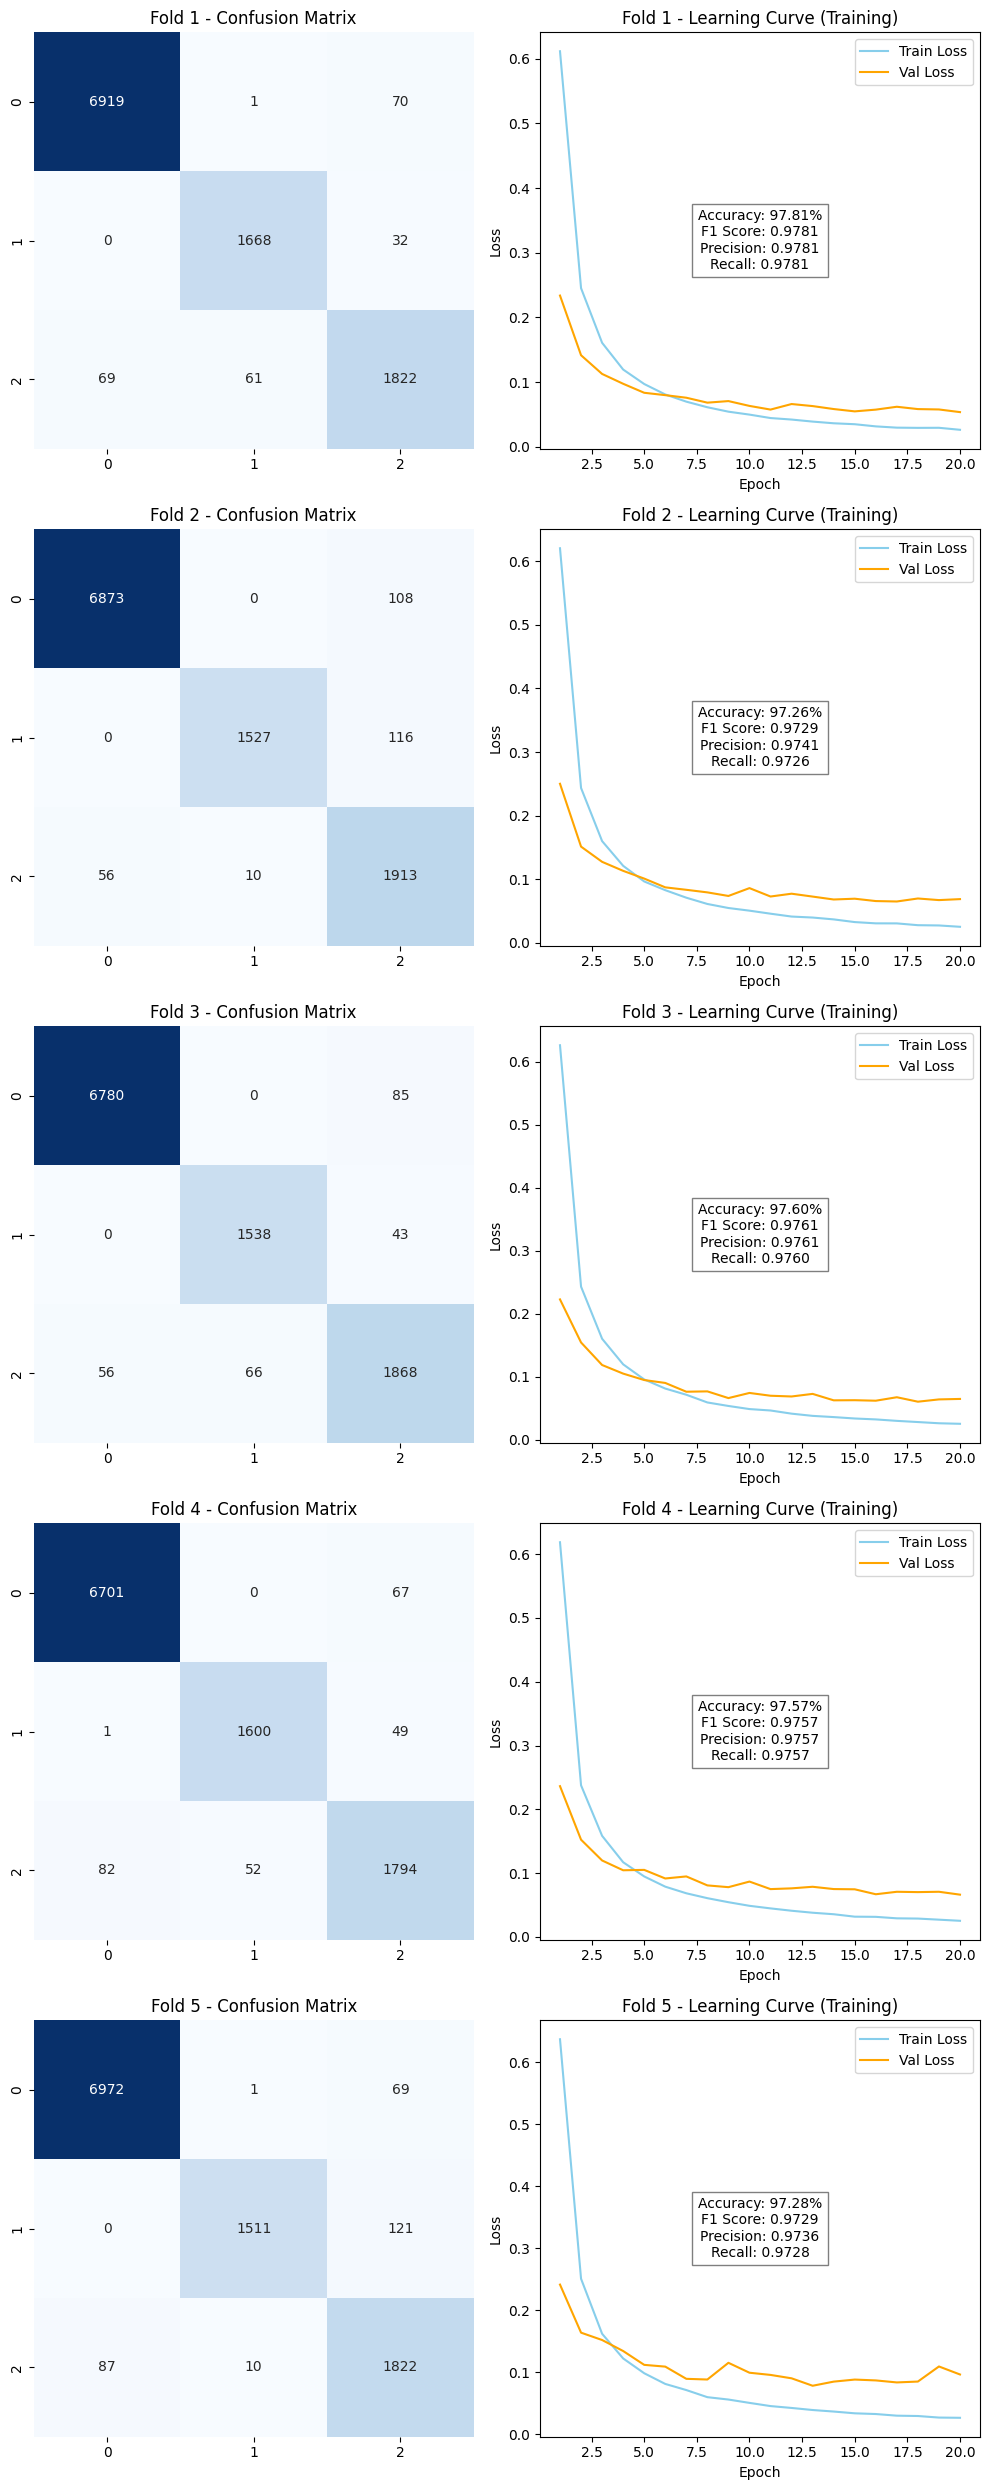

In [42]:
import seaborn as sns

fig, axes = plt.subplots(nrows=num_folds, ncols=2, figsize=(10, 5 * num_folds))
fig.subplots_adjust(hspace=0.5)

for fold in range(num_folds):
    conf_mat = conf_mat_list[fold]
    scores = loss_per_fold[fold]

    # Subplot 1: Confusion Matrix
    ax1 = axes[fold, 0]
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_title(f'Fold {fold + 1} - Confusion Matrix')

    # Subplot 2: Learning Curve (Training)
    ax2 = axes[fold, 1]
    ax2.plot(range(1, len(all_train_loss[fold]) + 1), all_train_loss[fold], color='skyblue', label='Train Loss')
    ax2.plot(range(1, len(all_val_loss[fold]) + 1), all_val_loss[fold], color='orange', label='Val Loss')

    ax2.set_title(f'Fold {fold + 1} - Learning Curve (Training)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Annotate with final values
    ax2.text(0.5, 0.5, f'Accuracy: {accuracy_per_fold[fold]*100:.2f}%\nF1 Score: {f1_per_fold[fold]:.4f}\nPrecision: {precision_per_fold[fold]:.4f}\nRecall: {recall_per_fold[fold]:.4f}',
             horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Display the subplots
plt.tight_layout()
plt.show()
